In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip uninstall sklearn -y
!pip install --upgrade sklearn
!pip install scikit-learn==0.23.2 --user
# 설치 후 런타임 다시시작

In [ ]:
import sklearn
!pip install pycaret
from pycaret.utils import enable_colab
enable_colab()
!pip install markupsafe==2.0.1
# 설치 후 런타임 다시시작

In [1]:
import jinja2
from pycaret.regression import *
!pip install catboost
!pip install optuna
import optuna 
from optuna import Trial, visualization
from optuna.samplers import TPESampler

/usr/local/lib/python3.7/dist-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 133 kB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 308 kB 2.7 MB/s 
     |████████████████████████████████| 81 kB 8.2 MB/s 
     |████████████████████████████████| 49 kB 224 kB/s 
     |████████████████████████████████| 147 kB 43.3 MB/s 
     |████████████████████████████████| 112 kB 56.9 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=e887c44de4c498199e49e4aaf26f9478add7ac1e1edd1e28a0a4b6fb6a438336
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [2]:
import numpy as np
import pandas as pd
import os
from glob import glob
from tqdm import tqdm
from scipy import interpolate
import pickle
import datetime as dt
import joblib
import time
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from itertools import permutations, combinations
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor, plot_tree, plot_importance
from lightgbm import LGBMRegressor
#from catboost import CatBoostClassifier, Pool, CatBoostRegressor
from sklearn import ensemble
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import AdaBoostRegressor,  HistGradientBoostingRegressor, StackingRegressor, RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
import math
import warnings
warnings.filterwarnings(action='ignore')
# 성능 평가
from sklearn.metrics import mean_squared_error
def RMSE(y_pred, y):
    return mean_squared_error(y_pred, y)**0.5

wr_list = sorted(glob("./drive/MyDrive/input/팔당댐 홍수 안전운영에 따른 한강 수위예측/water_rf_data/*.csv")) # 2012~2021 + 2022-05-01 00:00 ~ 2022-07-18 23:50 
sample_submission = pd.read_csv("./drive/MyDrive/input/팔당댐 홍수 안전운영에 따른 한강 수위예측/sample_submission.csv", index_col=0) # 2022-06-01 00:00	~ 2022-07-18 23:50	6912개
test_all = pd.read_csv('./drive/MyDrive/input/팔당댐 홍수 안전운영에 따른 한강 수위예측/test_all.csv')
test_all.columns = ['Unnamed: 0', 'wl_1018662', 'wl_1018680', 'wl_1018683', 'wl_1019630']

# 전체 데이터프레임 결합(2012~2021년)
df_list = []
for i in wr_list:
    df_list.append(pd.read_csv(i))
df = pd.concat(df_list, ignore_index=True)

# 결측치
df['fw_1018680'] = df['fw_1018680'].fillna(0)
df['sfw_ecpc'] = 244
df = df.drop(['ymdhm.1'], axis=1)

# 날짜 전처리
def date_conv(df):
    df['ymdhm'] = pd.to_datetime(df['ymdhm'])
    #df['year'] = df['ymdhm'].dt.year
    #df['month'] =df['ymdhm'].dt.month
    #df['day'] =df['ymdhm'].dt.day
    df['hour'] =df['ymdhm'].dt.hour
    df['minute'] =df['ymdhm'].dt.minute
    #df['weekday'] = df['ymdhm'].dt.weekday
    #df['year_month_day_hour_minute'] = df['ymdhm'].dt.strftime('%Y-%m-%d-%H-%M')
    df = df.drop('ymdhm', axis=1)
    return df
df = date_conv(df)
#df = df.drop(columns=['year', 'month', 'day', 'hour', 'minute', 'weekday'])
df.shape

(276336, 20)

In [3]:
# 방법3 interpolate 이용한 분석
Y = df[["wl_1018662", "wl_1018680", "wl_1018683", "wl_1019630"]]
#Y1 = df[["wl_1018662", "wl_1018680", "wl_1018683", "wl_1019630", 'year','month','day','hour']]
X = df.drop(columns=["wl_1018662", "wl_1018680", "wl_1018683", "wl_1019630"], axis=1)

# train, test셋 분리
'''train_target = Y.iloc[:268704, :]
train_target1 = Y1.iloc[:268704, :]
train_data = X.iloc[:268704, :]
test_target = Y.iloc[268704:, :]
test_target1 = Y1.iloc[268704:, :]
test_data = X.iloc[268704:, :]'''

'''train_target = Y.iloc[:269394, :]
#train_target1 = Y1.iloc[:269394, :]
train_data = X.iloc[:269394, :]
test_target = Y.iloc[269394:, :]
#test_target1 = Y1.iloc[269394:, :]
test_data = X.iloc[269394:, :]
'''
train_target = Y.iloc[:269424, :]
#train_target1 = Y1.iloc[:269424, :]
train_data = X.iloc[:269424, :]
test_target = Y.iloc[269424:, :]
#test_target1 = Y1.iloc[269424:, :]
test_data = X.iloc[269424:, :]

# 팔당댐 공용량 결측치 채우기
train_data['ecpc'] = train_data['ecpc'].interpolate()
test_data['ecpc'] = test_data['ecpc'].fillna(method = 'pad')

# 팔당댐 저수량 결측치 채우기
train_data['sfw'] = 244 - train_data['ecpc']
test_data['sfw'] = 244 - test_data['ecpc']

# 나머지 결측치 채우기
train_target = train_target.interpolate()
#train_target1 = train_target1.interpolate()
train_data = train_data.interpolate()
test_data = X.iloc[269424:, :].fillna(method = 'pad')
#test_data = X.iloc[269394:, :].fillna(method = 'pad')
#test_data = test_data.iloc[11:, :]

# 총 저수량 제거
train_data = train_data.drop(columns = ['sfw_ecpc'])
test_data = test_data.drop(columns = ['sfw_ecpc'])
df = df.drop(columns = ['sfw_ecpc'])
test_target = test_all.drop(columns=['Unnamed: 0'], axis=1)

print(train_data.shape, train_target.shape, test_data.shape, test_target.shape)


(269424, 15) (269424, 4) (6912, 15) (6912, 4)


In [4]:
data1 = pd.concat([train_data, test_data], axis=0)
data1 = data1.reset_index(drop=True)
data2 = pd.concat([train_target, test_target], axis=0)
data2 = data2.reset_index(drop=True)
data3 = pd.concat([data1, data2], axis=1)

In [5]:
def preprocess_data(data, is_train=True):
    df = data.copy()
    # 1. hour, minute를 1개 항목으로(float) 병합, day 항목 제거
    df['hour'] = df['hour'] + df['minute']/60
    df.drop(['minute'], axis=1, inplace=True)
    
    # 2. sin, cos함수를 이용한 시간의 연속적 표현 
    #df['cos_time'] = np.cos(2*np.pi*(df['hour']/24))
    #df['sin_time'] = np.sin(2*np.pi*(df['hour']/24))
    
    # 3. 3일치, 5일치 평균 발전량 
    # wl_1018662 : 청담대교 
    df['wl_1018662_shft1'] = df['wl_1018662'].shift(1) # 10분 전 수위
    df['wl_1018662_shft2'] = df['wl_1018662'].shift(1*2) # 20분 전 수위
    df['wl_1018662_shft3'] = df['wl_1018662'].shift(1*3) # 30분 전 수위
    df['wl_1018662_shft4'] = df['wl_1018662'].shift(1*4) # 40분 전 수위
    df['wl_1018662_shft5'] = df['wl_1018662'].shift(1*5) # 50분 전 수위
    df['wl_1018662_shft6'] = df['wl_1018662'].shift(1*6) # 60분 전 수위
    df['wl_1018662_avg3'] = np.mean(df[['wl_1018662_shft1', 'wl_1018662_shft2', 'wl_1018662_shft3']].values, axis=-1) # 3일치 평균 발전량 
    df['wl_1018662_avg5'] = np.mean(df[['wl_1018662_shft1', 'wl_1018662_shft1', 'wl_1018662_shft2', 'wl_1018662_shft3','wl_1018662_shft4', 'wl_1018662_shft5']].values, axis=-1) # 5일치 평균 발전량 
    #df['wl_1018662_avg2'] = np.mean(df[['wl_1018662_shft1', 'wl_1018662_shft2']].values, axis=-1) # 3일치 평균 발전량 
    #df['wl_1018662_avg4'] = np.mean(df[['wl_1018662_shft1', 'wl_1018662_shft1', 'wl_1018662_shft2', 'wl_1018662_shft3','wl_1018662_shft4']].values, axis=-1) # 5일치 평균 발전량 
    #df['wl_1018662_avg6'] = np.mean(df[['wl_1018662_shft1', 'wl_1018662_shft1', 'wl_1018662_shft2', 'wl_1018662_shft3','wl_1018662_shft4', 'wl_1018662_shft5', 'wl_1018662_shft6']].values, axis=-1) # 5일치 평균 발전량 
    #df.drop(['wl_1018662_shft4', 'wl_1018662_shft5'], axis=1, inplace=True)

    # wl_1018680 : 잠수교 
    df['wl_1018680_shft1'] = df['wl_1018680'].shift(1) # 10분 전 수위
    df['wl_1018680_shft2'] = df['wl_1018680'].shift(1*2) # 20분 전 수위
    df['wl_1018680_shft3'] = df['wl_1018680'].shift(1*3) # 30분 전 수위
    df['wl_1018680_shft4'] = df['wl_1018680'].shift(1*4) # 40분 전 수위
    df['wl_1018680_shft5'] = df['wl_1018680'].shift(1*5) # 50분 전 수위
    df['wl_1018680_shft6'] = df['wl_1018680'].shift(1*6) # 60분 전 수위
    df['wl_1018680_avg3'] = np.mean(df[['wl_1018680_shft1', 'wl_1018680_shft2', 'wl_1018680_shft3']].values, axis=-1) # 3일치 평균 발전량 
    df['wl_1018680_avg5'] = np.mean(df[['wl_1018680_shft1', 'wl_1018680_shft1', 'wl_1018680_shft2', 'wl_1018680_shft3','wl_1018680_shft4', 'wl_1018680_shft5']].values, axis=-1) # 5일치 평균 발전량 
    #df['wl_1018680_avg2'] = np.mean(df[['wl_1018680_shft1', 'wl_1018680_shft2']].values, axis=-1) # 3일치 평균 발전량 
    #df['wl_1018680_avg4'] = np.mean(df[['wl_1018680_shft1', 'wl_1018680_shft1', 'wl_1018680_shft2', 'wl_1018680_shft3','wl_1018680_shft4']].values, axis=-1) # 5일치 평균 발전량 
    #df['wl_1018680_avg6'] = np.mean(df[['wl_1018680_shft1', 'wl_1018680_shft1', 'wl_1018680_shft2', 'wl_1018680_shft3','wl_1018680_shft4', 'wl_1018680_shft5', 'wl_1018680_shft6']].values, axis=-1) # 5일치 평균 발전량  
    #df.drop(['wl_1018680_shft4', 'wl_1018680_shft5'], axis=1, inplace=True)

    # wl_1018683 : 한강대교 
    df['wl_1018683_shft1'] = df['wl_1018683'].shift(1) # 10분 전 수위
    df['wl_1018683_shft2'] = df['wl_1018683'].shift(1*2) # 20분 전 수위
    df['wl_1018683_shft3'] = df['wl_1018683'].shift(1*3) # 30분 전 수위
    df['wl_1018683_shft4'] = df['wl_1018683'].shift(1*4) # 40분 전 수위
    df['wl_1018683_shft5'] = df['wl_1018683'].shift(1*5) # 50분 전 수위
    df['wl_1018683_shft6'] = df['wl_1018683'].shift(1*6) # 60분 전 수위
    df['wl_1018683_avg3'] = np.mean(df[['wl_1018683_shft1', 'wl_1018683_shft2', 'wl_1018683_shft3']].values, axis=-1) # 3일치 평균 발전량 
    df['wl_1018683_avg5'] = np.mean(df[['wl_1018683_shft1', 'wl_1018683_shft1', 'wl_1018683_shft2', 'wl_1018683_shft3','wl_1018683_shft4', 'wl_1018683_shft5']].values, axis=-1) # 5일치 평균 발전량 
    #df['wl_1018683_avg2'] = np.mean(df[['wl_1018683_shft1', 'wl_1018683_shft2']].values, axis=-1) # 3일치 평균 발전량 
    #df['wl_1018683_avg4'] = np.mean(df[['wl_1018683_shft1', 'wl_1018683_shft1', 'wl_1018683_shft2', 'wl_1018683_shft3','wl_1018683_shft4']].values, axis=-1) # 5일치 평균 발전량 
    #df['wl_1018683_avg6'] = np.mean(df[['wl_1018683_shft1', 'wl_1018683_shft1', 'wl_1018683_shft2', 'wl_1018683_shft3','wl_1018683_shft4', 'wl_1018683_shft5', 'wl_1018683_shft6']].values, axis=-1) # 5일치 평균 발전량 
    #df.drop(['wl_1018683_shft4', 'wl_1018683_shft5'], axis=1, inplace=True)

    # wl_1019630 : 행주대교 
    df['wl_1019630_shft1'] = df['wl_1019630'].shift(1) # 10분 전 수위
    df['wl_1019630_shft2'] = df['wl_1019630'].shift(1*2) # 20분 전 수위
    df['wl_1019630_shft3'] = df['wl_1019630'].shift(1*3) # 30분 전 수위
    df['wl_1019630_shft4'] = df['wl_1019630'].shift(1*4) # 40분 전 수위
    df['wl_1019630_shft5'] = df['wl_1019630'].shift(1*5) # 50분 전 수위
    df['wl_1019630_shft6'] = df['wl_1019630'].shift(1*6) # 60분 전 수위
    df['wl_1019630_avg3'] = np.mean(df[['wl_1019630_shft1', 'wl_1019630_shft2', 'wl_1019630_shft3']].values, axis=-1) # 3일치 평균 발전량 
    df['wl_1019630_avg5'] = np.mean(df[['wl_1019630_shft1', 'wl_1019630_shft1', 'wl_1019630_shft2', 'wl_1019630_shft3','wl_1019630_shft4', 'wl_1019630_shft5']].values, axis=-1) # 5일치 평균 발전량
    #df['wl_1019630_avg2'] = np.mean(df[['wl_1019630_shft1', 'wl_1019630_shft2']].values, axis=-1) # 3일치 평균 발전량 
    #df['wl_1019630_avg4'] = np.mean(df[['wl_1019630_shft1', 'wl_1019630_shft1', 'wl_1019630_shft2', 'wl_1019630_shft3','wl_1019630_shft4']].values, axis=-1) # 5일치 평균 발전량 
    #df['wl_1019630_avg6'] = np.mean(df[['wl_1019630_shft1', 'wl_1019630_shft1', 'wl_1019630_shft2', 'wl_1019630_shft3','wl_1019630_shft4', 'wl_1019630_shft5', 'wl_1019630_shft6']].values, axis=-1) # 5일치 평균 발전량 
    #df.drop(['wl_1019630_shft4', 'wl_1019630_shft5'], axis=1, inplace=True)

    
    #if is_train==True:          
    #    df['Target1'] = df['TARGET'].shift(-48) # 1일후 발전량
    #    df['Target2'] = df['TARGET'].shift(-48*2) # 2일후 발전량
    #else:
    #    pass

    return df

df = preprocess_data(data3)
df = df.iloc[1*6:,:]
df.shape

(276330, 50)

In [6]:
Y = df[["wl_1018662", "wl_1018680", "wl_1018683", "wl_1019630"]]
#Y1 = df[["wl_1018662", "wl_1018680", "wl_1018683", "wl_1019630", 'year','month','day','hour']]
X = df.drop(columns=["wl_1018662", "wl_1018680", "wl_1018683", "wl_1019630"], axis=1)
Y = Y.reset_index(drop=True)
X = X.reset_index(drop=True)


train_target = Y.iloc[:269418, :]
#train_target1 = Y1.iloc[:269348, :]
train_data = X.iloc[:269418, :]
test_target = Y.iloc[269418:, :]

#test_target1 = Y1.iloc[269348:, :]
test_data = X.iloc[269418:, :]
test_data.iloc[:, 13:]

print(train_data.shape, train_target.shape, test_data.shape, test_target.shape)

(269418, 46) (269418, 4) (6912, 46) (6912, 4)


In [ ]:
train_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
swl,269418.0,25.073761,0.463724,0.000000,24.980000,2.510900e+01,25.192000,25.449000
inf,269418.0,543.251987,1105.716275,-990.000000,127.170000,2.480000e+02,522.000000,25991.500000
sfw,269418.0,219.566826,10.641723,-0.010000,212.140000,2.179700e+02,229.610000,241.850000
ecpc,269418.0,24.433174,10.641723,2.150000,14.390000,2.603000e+01,31.860000,244.010000
tototf,269418.0,537.585176,1101.519160,-990.000000,132.000000,1.743000e+02,496.775000,25791.500000
tide_level,269418.0,345.365376,174.292766,39.000000,192.000000,3.240000e+02,487.000000,842.000000
fw_1018662,269418.0,743.564365,1066.449138,243.290000,319.840000,4.479300e+02,725.690000,9405.640000
fw_1018680,269418.0,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
fw_1018683,269418.0,595.155077,1368.776928,-3522.710000,205.230000,3.544700e+02,704.372500,25289.170000
fw_1019630,269418.0,1053.710113,1422.680566,212.040000,449.120000,6.794200e+02,1142.220000,29854.120000


In [7]:
# 변수 생성
# swl : 팔당댐 현재수위 (단위: El.m) 0, 23~25
# inf : 팔당댐 유입량 (단위: m^3/s) 0, -990 ~ 25991.5
# sfw : 팔당댐 저수량 (단위: 만m^3) 0,
# ecpc : 팔당댐 공용량 (단위: 백만m^3) 0X, 
# tototf : 총 방류량 (단위: m^3/s) 0, 
# tide_level : 강화대교 조위 (단위: cm) 0X, 
# fw_1018662 : 청담대교 유량 (단위: m^3/s) 주소: 서울특별시 광진구 자양동 0X, 
# fw_1018680 : 잠수교 유량 (단위: m^3/s) 주소: 서울특별시 서초구 반포동 전부 0
# fw_1018683 : 한강대교 유량 (단위: m^3/s) 서울특별시 용산구 이촌동 0, 
# fw_1019630 : 행주대교 유량 (단위: m^3/s) 주소: 서울특별시 강서구 방화동 0X, 

from itertools import permutations, combinations

target_columns1 = ['inf', 'tototf']
target_columns2 = ['inf', 'tototf']
target_columns3 = ['swl', 'ecpc']
target_columns4 = ['inf', 'ecpc']
target_columns5 = ['tototf', 'ecpc']
target_columns6 = ['tide_level', 'ecpc']
target_columns7 = ['fw_1018683', 'fw_1018662']
target_columns8 = ['fw_1019630', 'fw_1018662']

combis1 = list(combinations(target_columns1, 2))
combis2 = list(combinations(target_columns2, 2))
combis3 = list(combinations(target_columns3, 2))
combis4 = list(combinations(target_columns4, 2))
combis5 = list(combinations(target_columns5, 2))
combis6 = list(combinations(target_columns6, 2))
combis7 = list(combinations(target_columns7, 2))
combis8 = list(combinations(target_columns8, 2))

def plusmult(df, combis):
    for com in combis:
        df['{}*{}'.format(com[0], com[1])] = df['{}'.format(com[0])] * df['{}'.format(com[1])]
        df['{}+{}'.format(com[0], com[1])] = df['{}'.format(com[0])] + df['{}'.format(com[1])]
    return df

def div(df, combis):
    for com in combis:
        df['{}/{}'.format(com[0], com[1])] = df['{}'.format(com[0])] / df['{}'.format(com[1])]
    return df

train_data = plusmult(train_data, combis1)
test_data = plusmult(test_data, combis1)

train_data = div(train_data, combis3)
test_data = div(test_data, combis3)
train_data = div(train_data, combis4)
test_data = div(test_data, combis4)
train_data = div(train_data, combis5)
test_data = div(test_data, combis5)
train_data = div(train_data, combis6)
test_data = div(test_data, combis6)
train_data = div(train_data, combis7)
test_data = div(test_data, combis7)
train_data = div(train_data, combis8)
test_data = div(test_data, combis8)

print(train_data.shape, train_target.shape, test_data.shape, test_target.shape)
train_data.info()

(269418, 54) (269418, 4) (6912, 54) (6912, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 269418 entries, 0 to 269417
Data columns (total 54 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   swl                    269418 non-null  float64
 1   inf                    269418 non-null  float64
 2   sfw                    269418 non-null  float64
 3   ecpc                   269418 non-null  float64
 4   tototf                 269418 non-null  float64
 5   tide_level             269418 non-null  float64
 6   fw_1018662             269418 non-null  float64
 7   fw_1018680             269418 non-null  float64
 8   fw_1018683             269418 non-null  float64
 9   fw_1019630             269418 non-null  float64
 10  rf_10184100            269418 non-null  float64
 11  rf_10184110            269418 non-null  float64
 12  rf_10184140            269418 non-null  float64
 13  hour                   269418 non-null  flo

In [ ]:
# 변수 제거
train_data = train_data.drop(columns = ['swl', 'sfw', 'ecpc', 'tide_level', 'fw_1018680', 'hour', 'rf_10184100', 'rf_10184110', 'rf_10184140'], axis=1)
test_data = test_data.drop(columns = ['swl', 'sfw', 'ecpc', 'tide_level', 'fw_1018680', 'hour', 'rf_10184100', 'rf_10184110', 'rf_10184140'], axis=1)
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 269418 entries, 0 to 269417
Data columns (total 39 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   inf               269418 non-null  float64
 1   tototf            269418 non-null  float64
 2   fw_1018662        269418 non-null  float64
 3   fw_1018683        269418 non-null  float64
 4   fw_1019630        269418 non-null  float64
 5   wl_1018662_shft1  269418 non-null  float64
 6   wl_1018662_shft2  269418 non-null  float64
 7   wl_1018662_shft3  269418 non-null  float64
 8   wl_1018662_shft4  269418 non-null  float64
 9   wl_1018662_shft5  269418 non-null  float64
 10  wl_1018662_shft6  269418 non-null  float64
 11  wl_1018662_avg3   269418 non-null  float64
 12  wl_1018662_avg5   269418 non-null  float64
 13  wl_1018680_shft1  269418 non-null  float64
 14  wl_1018680_shft2  269418 non-null  float64
 15  wl_1018680_shft3  269418 non-null  float64
 16  wl_1018680_shft4  26

In [ ]:
from sklearn import ensemble
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

rf = RandomForestRegressor()
#rf.fit(train_data, train_target)
rf.fit(train_data, train_target)
pred = rf.predict(test_data)

# RMSE로 예측 평가
rmse = RMSE(pred, test_target) #2.5508483611995882
print(rmse)

sample_submission.iloc[:,:] = pred
sample_submission.to_csv('ans1.csv')
sample_submission

#,swl,inf,sfw,ecpc,tototf,tide_level,fw_1018662,fw_1018680,fw_1018683,fw_1019630,rf_10184100,rf_10184110,rf_10184140,hour,wl_1018662,wl_1018680,wl_1018683,wl_1019630,wl_1019630_avg5  => 2.0218346640385865
# ,swl,inf,sfw,ecpc,tototf,tide_level,fw_1018662,fw_1018680,fw_1018683,fw_1019630,rf_10184100,rf_10184110,rf_10184140,hour,wl_1018662,wl_1018680,wl_1018683,wl_1019630,wl_1018662_shft1,wl_1018662_shft2,wl_1018662_shft3,wl_1018662_shft4,wl_1018662_shft5,wl_1018662_avg3,wl_1018662_avg5,wl_1018680_shft1,wl_1018680_shft2,wl_1018680_shft3,wl_1018680_shft4,wl_1018680_shft5,wl_1018680_avg3,wl_1018680_avg5,wl_1018683_shft1,wl_1018683_shft2,wl_1018683_shft3,wl_1018683_shft4,wl_1018683_shft5,wl_1018683_avg3,wl_1018683_avg5,wl_1019630_shft1,wl_1019630_shft2,wl_1019630_shft3,wl_1019630_shft4,wl_1019630_shft5,wl_1019630_avg3,wl_1019630_avg5 => 1.5948415817504134
# ,swl,inf,sfw,ecpc,tototf,tide_level,fw_1018662,fw_1018680,fw_1018683,fw_1019630,rf_10184100,rf_10184110,rf_10184140,hour,wl_1018662,wl_1018680,wl_1018683,wl_1019630,wl_1018662_shft1,wl_1018662_shft2,wl_1018662_shft3,wl_1018662_avg3,wl_1018662_avg5,wl_1018680_shft1,wl_1018680_shft2,wl_1018680_shft3,wl_1018680_avg3,wl_1018680_avg5,wl_1018683_shft1,wl_1018683_shft2,wl_1018683_shft3,wl_1018683_avg3,wl_1018683_avg5,wl_1019630_shft1,wl_1019630_shft2,wl_1019630_shft3,wl_1019630_avg3,wl_1019630_avg5 => 1.6128160550236443
# ,inf,tototf,fw_1018662,fw_1018683,fw_1019630,wl_1018662_shft1,wl_1018662_shft2,wl_1018662_shft3,wl_1018662_shft4,wl_1018662_shft5,wl_1018662_avg3,wl_1018662_avg5,wl_1018680_shft1,wl_1018680_shft2,wl_1018680_shft3,wl_1018680_shft4,wl_1018680_shft5,wl_1018680_avg3,wl_1018680_avg5,wl_1018683_shft1,wl_1018683_shft2,wl_1018683_shft3,wl_1018683_shft4,wl_1018683_shft5,wl_1018683_avg3,wl_1018683_avg5,wl_1019630_shft1,wl_1019630_shft2,wl_1019630_shft3,wl_1019630_shft4,wl_1019630_shft5,wl_1019630_avg3,wl_1019630_avg5 => 1.5884383781692275
#,inf,tototf,fw_1018662,fw_1018683,fw_1019630,wl_1018662_shft1,wl_1018662_shft2,wl_1018662_shft3,wl_1018662_shft4,wl_1018662_shft5,wl_1018662_shft6,wl_1018662_avg3,wl_1018662_avg5,wl_1018680_shft1,wl_1018680_shft2,wl_1018680_shft3,wl_1018680_shft4,wl_1018680_shft5,wl_1018680_shft6,wl_1018680_avg3,wl_1018680_avg5,wl_1018683_shft1,wl_1018683_shft2,wl_1018683_shft3,wl_1018683_shft4,wl_1018683_shft5,wl_1018683_shft6,wl_1018683_avg3,wl_1018683_avg5,wl_1019630_shft1,wl_1019630_shft2,wl_1019630_shft3,wl_1019630_shft4,wl_1019630_shft5,wl_1019630_shft6,wl_1019630_avg3,wl_1019630_avg5 => 1.5814062763694907
#,inf,tototf,fw_1018662,fw_1018683,fw_1019630,wl_1018662_shft1,wl_1018662_shft2,wl_1018662_shft3,wl_1018662_shft4,wl_1018662_shft5,wl_1018662_shft6,wl_1018662_avg3,wl_1018662_avg5,wl_1018680_shft1,wl_1018680_shft2,wl_1018680_shft3,wl_1018680_shft4,wl_1018680_shft5,wl_1018680_shft6,wl_1018680_avg3,wl_1018680_avg5,wl_1018683_shft1,wl_1018683_shft2,wl_1018683_shft3,wl_1018683_shft4,wl_1018683_shft5,wl_1018683_shft6,wl_1018683_avg3,wl_1018683_avg5,wl_1019630_shft1,wl_1019630_shft2,wl_1019630_shft3,wl_1019630_shft4,wl_1019630_shft5,wl_1019630_shft6,wl_1019630_avg3,wl_1019630_avg5,tototf,tototf => 1.5842955270333035
# ,inf,tototf,fw_1018662,fw_1018683,fw_1019630,wl_1018662_shft1,wl_1018662_shft2,wl_1018662_shft3,wl_1018662_shft4,wl_1018662_shft5,wl_1018662_shft6,wl_1018662_avg3,wl_1018662_avg5,wl_1018680_shft1,wl_1018680_shft2,wl_1018680_shft3,wl_1018680_shft4,wl_1018680_shft5,wl_1018680_shft6,wl_1018680_avg3,wl_1018680_avg5,wl_1018683_shft1,wl_1018683_shft2,wl_1018683_shft3,wl_1018683_shft4,wl_1018683_shft5,wl_1018683_shft6,wl_1018683_avg3,wl_1018683_avg5,wl_1019630_shft1,wl_1019630_shft2,wl_1019630_shft3,wl_1019630_shft4,wl_1019630_shft5,wl_1019630_shft6,wl_1019630_avg3,wl_1019630_avg5,inf*tototf, inf+tototf=> 1.5800890276510384
#



1.6249274484692038


,wl_1018662,wl_1018680,wl_1018683,wl_1019630
ymdhm,,,,
2022-06-01 00:00,278.43,276.37,275.06,269.49
2022-06-01 00:10,280.55,276.84,274.27,266.87
2022-06-01 00:20,284.71,276.46,273.85,264.02
2022-06-01 00:30,284.90,276.70,273.43,261.44
2022-06-01 00:40,284.11,277.40,272.80,258.85
...,...,...,...,...
2022-07-18 23:10,287.13,293.44,299.41,305.69
2022-07-18 23:20,290.21,302.23,305.82,307.30
2022-07-18 23:30,299.57,306.26,308.25,308.44


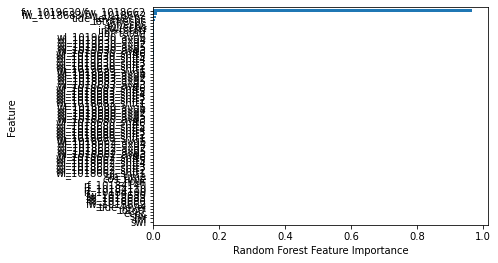

In [ ]:
import matplotlib.pyplot as plt

def plot_feature_importance(model):
    n_features = train_data.shape[1]
    plt.barh(np.arange(n_features), sorted(model.feature_importances_), align="center")
    plt.yticks(np.arange(n_features), train_data.columns)
    plt.xlabel("Random Forest Feature Importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)
    
plot_feature_importance(rf)

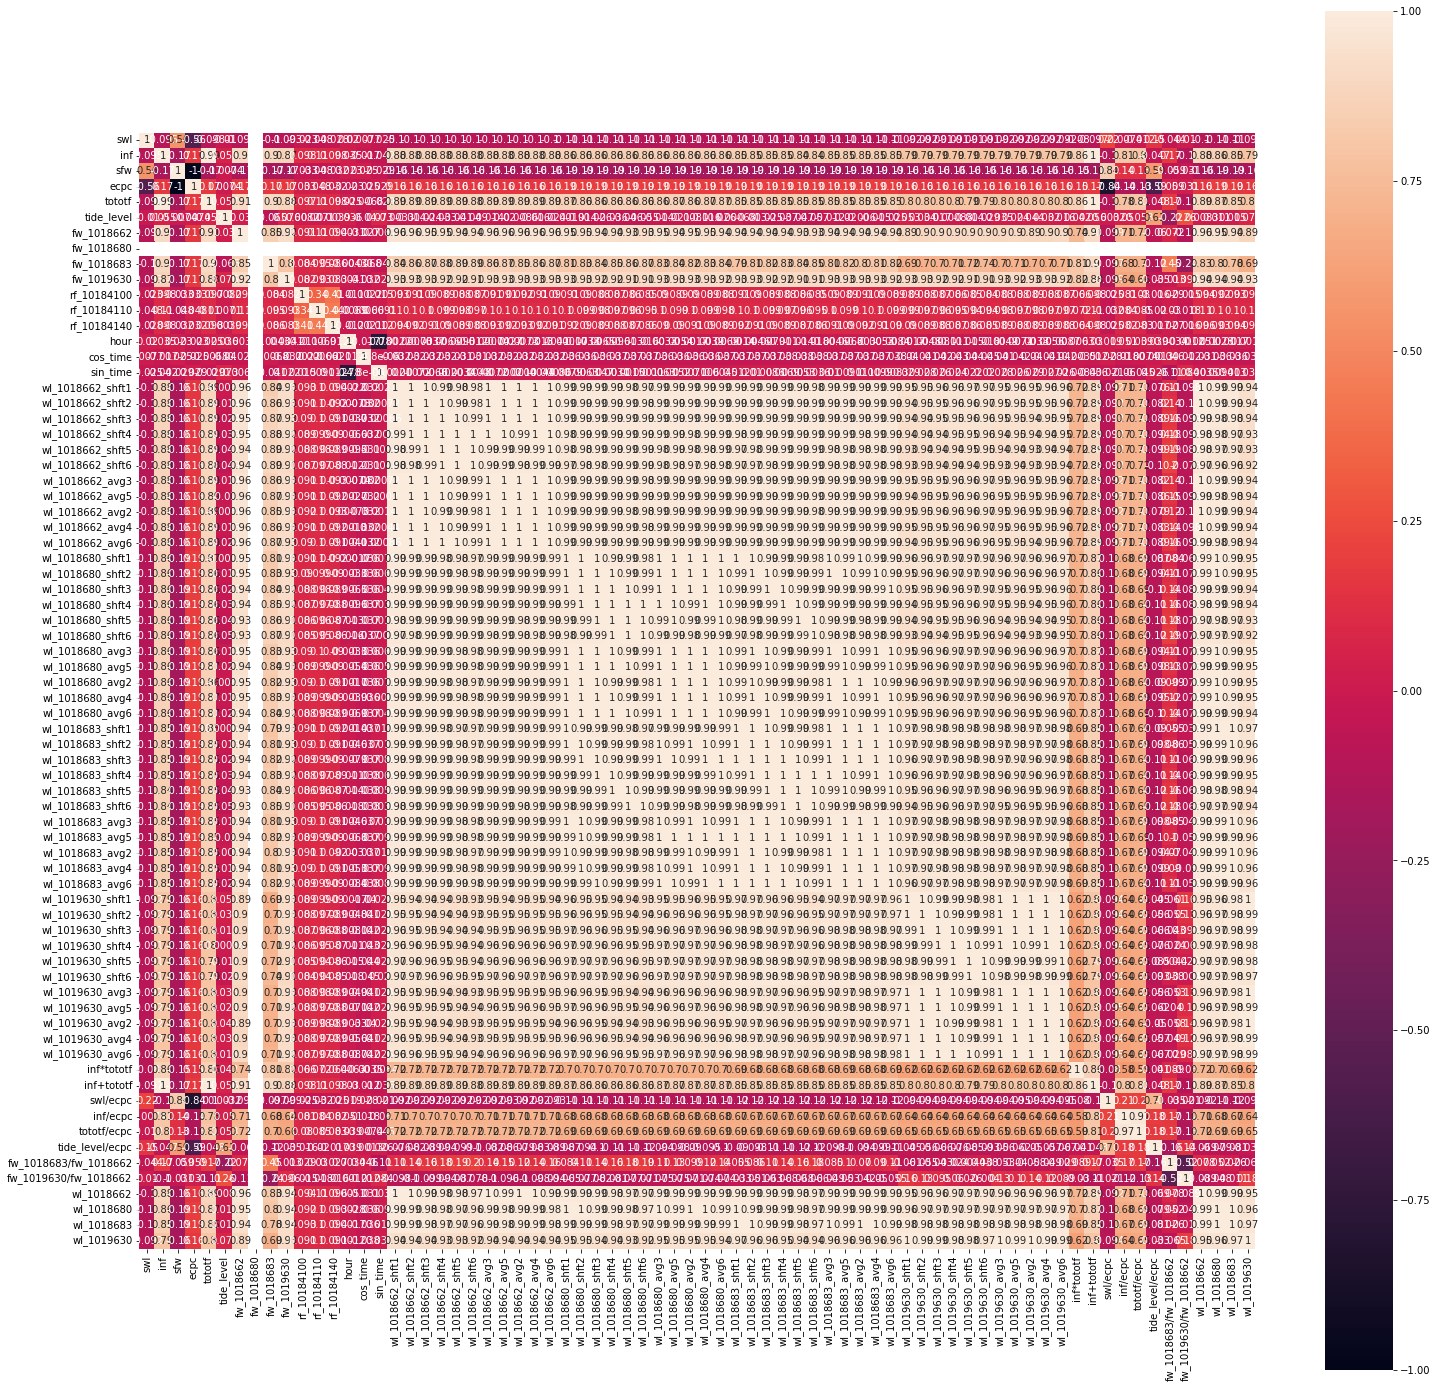

In [ ]:
## chk data correlation
import seaborn as sns

f, ax = plt.subplots(figsize=(25,25))
X1 = pd.concat([train_data, train_target], axis=1)
corr = X1.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), square=True, annot=True, ax=ax)

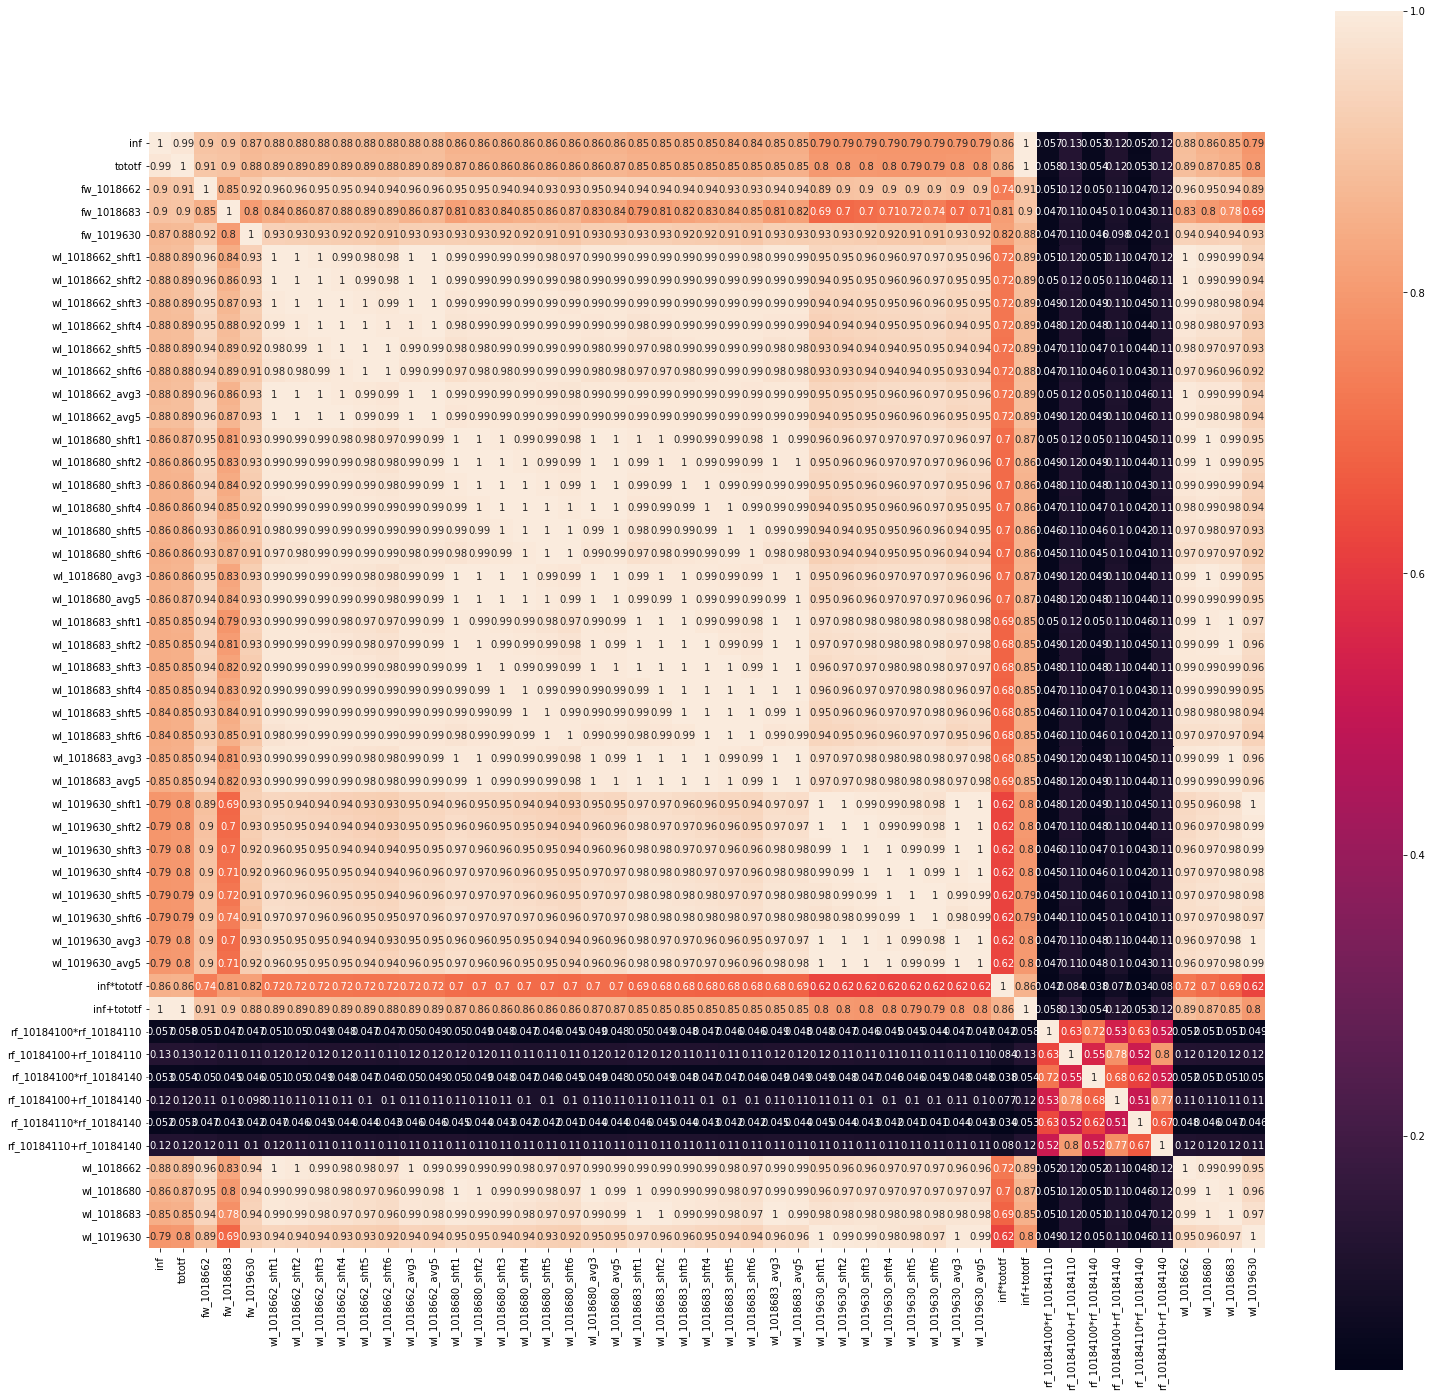

In [ ]:
## chk data correlation
import seaborn as sns

f, ax = plt.subplots(figsize=(25,25))
X1 = pd.concat([train_data, train_target], axis=1)
corr = X1.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), square=True, annot=True, ax=ax)

In [ ]:
train_target.isnull().sum()

wl_1018662    0
wl_1018680    0
wl_1018683    0
wl_1019630    0
dtype: int64

In [ ]:
train_data = train_data.drop(columns = ['swl', 'sfw', 'ecpc', 'tide_level', 'fw_1018683', 'hour', 'rf_10184100', 'rf_10184110', 'rf10184140'], axis=1)
test_data = test_data.drop(columns = ['swl', 'sfw', 'ecpc', 'tide_level', 'fw_1018683', 'hour', 'rf_10184100', 'rf_10184110', 'rf10184140'], axis=1)



,swl,inf,sfw,ecpc,tototf,tide_level,fw_1018662,fw_1018680,fw_1018683,fw_1019630,...,wl_1018683_avg5,wl_1019630_shft1,wl_1019630_shft2,wl_1019630_shft3,wl_1019630_avg3,wl_1019630_avg5,wl_1018662,wl_1018680,wl_1018683,wl_1019630
0,24.789,478.10,218.69,25.31,576.40,447.0,476.21,0.0,690.29,564.29,...,290.333333,277.3,276.3,275.3,276.300000,276.133333,311.7,301.2,291.0,277.3
1,24.790,464.00,218.73,25.27,562.00,442.0,483.42,0.0,666.66,564.29,...,290.500000,277.3,277.3,276.3,276.966667,276.466667,312.7,301.2,291.0,277.3
2,24.789,563.10,218.69,25.31,563.10,436.0,476.21,0.0,629.53,564.29,...,290.666667,277.3,277.3,277.3,277.300000,276.800000,311.7,301.2,291.0,277.3
3,24.789,576.40,218.69,25.31,576.40,428.0,483.42,0.0,617.71,576.54,...,290.833333,277.3,277.3,277.3,277.300000,277.133333,312.7,301.2,291.0,278.3
4,24.789,576.40,218.69,25.31,576.40,420.0,483.42,0.0,597.46,576.54,...,291.000000,278.3,277.3,277.3,277.633333,277.633333,312.7,301.2,291.0,278.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269414,25.180,140.94,217.99,26.01,140.94,220.0,285.72,0.0,575.57,493.58,...,281.666667,269.3,266.3,261.3,265.633333,264.300000,281.7,281.2,278.0,271.3
269415,25.180,141.07,217.99,26.01,141.07,208.0,274.78,0.0,501.04,505.03,...,279.833333,271.3,269.3,266.3,268.966667,266.633333,279.7,279.2,278.0,272.3
269416,25.180,141.01,217.99,26.01,141.01,196.0,269.40,0.0,425.89,505.03,...,279.166667,272.3,271.3,269.3,270.966667,268.800000,278.7,277.2,277.0,272.3
269417,25.190,755.75,218.36,25.64,140.75,184.0,264.07,0.0,198.19,493.58,...,278.333333,272.3,272.3,271.3,271.966667,270.633333,277.7,276.2,276.0,271.3


In [ ]:
# 4. 순환하면서 변수 제거/후진소거법 (https://process-mining.tistory.com/138)
from sklearn.feature_selection import RFECV 
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression

#target = train['rental']
#train1 = train.drop(['rental'], axis=1)
#model = LinearRegression()
selector = RFECV(rf, step=1, scoring = 'neg_mean_squared_error')
selector.fit(train_data, train_target)
selector.n_features_ # 117

train2 = selector.transform(train_data)
selected_features = train_data.columns[np.where(selector.ranking_==1)]
train_selected = pd.DataFrame(train2, columns = selected_features)
train_selected

test2 = selector.transform(test_data)
selected_features = test_data.columns[np.where(selector.ranking_==1)]
test_selected = pd.DataFrame(test2, columns = selected_features)
test_selected

In [ ]:
train_selected.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 269418 entries, 0 to 269417
Data columns (total 54 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   swl               269418 non-null  float64
 1   sfw               269418 non-null  float64
 2   ecpc              269418 non-null  float64
 3   tide_level        269418 non-null  float64
 4   rf_10184100       269418 non-null  float64
 5   rf_10184110       269418 non-null  float64
 6   rf_10184140       269418 non-null  float64
 7   hour              269418 non-null  float64
 8   cos_time          269418 non-null  float64
 9   sin_time          269418 non-null  float64
 10  wl_1018662_shft1  269418 non-null  float64
 11  wl_1018662_shft2  269418 non-null  float64
 12  wl_1018662_shft3  269418 non-null  float64
 13  wl_1018662_shft4  269418 non-null  float64
 14  wl_1018662_shft5  269418 non-null  float64
 15  wl_1018662_shft6  269418 non-null  float64
 16  wl_1018662_avg3   26

In [ ]:
train_target

,wl_1018662,wl_1018680,wl_1018683,wl_1019630
0,312.7,301.2,291.0,277.3
1,311.7,301.2,291.0,277.3
2,312.7,301.2,291.0,278.3
3,312.7,301.2,291.0,278.3
4,311.7,301.2,291.0,278.3
...,...,...,...,...
269413,281.7,281.2,278.0,271.3
269414,279.7,279.2,278.0,272.3
269415,278.7,277.2,277.0,272.3
269416,277.7,276.2,276.0,271.3


In [ ]:
pip install eli5

In [ ]:
import eli5 #5살도 이해할수있는 함수
from eli5.sklearn import PermutationImportance
model = RandomForestRegressor().fit(train_data, train_target)
perm = PermutationImportance(model).fit(train_data, train_target)
eli5.show_weights(perm, top = 80, feature_names = train_data.columns.tolist())


Weight,Feature
1.3613 ± 0.0028,wl_1018683_shft1
0.1325 ± 0.0003,fw_1019630
0.0221 ± 0.0000,fw_1018662
0.0076 ± 0.0000,wl_1018680_shft1
0.0004 ± 0.0000,wl_1018683_avg2
0.0003 ± 0.0000,fw_1018683
0.0002 ± 0.0000,wl_1018662_shft1
0.0002 ± 0.0000,wl_1018662_shft3
0.0002 ± 0.0000,wl_1019630_shft1
0.0001 ± 0.0000,wl_1018662_avg6


In [ ]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt


## 전진 선택법
variables = train1.columns.tolist() ## 설명 변수 리스트

selected_variables = [] ## 선택된 변수들
sl_enter = 0.05
 
sv_per_step = [] ## 각 스텝별로 선택된 변수들
adjusted_r_squared = [] ## 각 스텝별 수정된 결정계수
steps = [] ## 스텝
step = 0

while len(variables) > 0:
    remainder = list(set(variables) - set(selected_variables))
    pval = pd.Series(index=remainder) ## 변수의 p-value
    for col in remainder: 
        X = sm.add_constant(train[selected_variables+[col]])
        model = sm.OLS(target, X).fit()
        pval[col] = model.pvalues[col]
 
    min_pval = pval.min()
    if min_pval < sl_enter: ## 최소 p-value 값이 기준 값보다 작으면 포함
        selected_variables.append(pval.idxmin())
        
        step += 1
        steps.append(step)
        adj_r_squared = sm.OLS(target, sm.add_constant(train[selected_variables])).fit().rsquared_adj
        adjusted_r_squared.append(adj_r_squared)
        sv_per_step.append(selected_variables.copy())
    else:
        break

In [8]:
# 3시간
from optuna import Trial, visualization
import numpy as np

def RMSE(true, pred):
    score = np.sqrt(((true - pred) ** 2).mean())
    return score
    
def objective(trial: Trial, X, y):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 300, step=10), # 트리의 개수
        'max_features': trial.suggest_int('max_features', 20, X.shape[1], step=1), # 변수의 개수
        #'max_depth' : trial.suggest_int("max_depth", 2, 8) # 기본값=None(무제한)
        "random_state": 357,
        #'criterion': trial.suggest_categorical('criterion', ['mse']) # 표준평가 기준
        #'min_samples_split': trial.suggest_int('min_samples_split', ) # 기본값=2
        #'min_samples_leaf': trial.suggest_int('min_samples_leaf', ) # 기본값=1
        #'min_weight_fraction_leaf': trial.suggest_int('min_samples_leaf', )
        #'max_leaf_nodes':  trial.suggest_int('max_leaf_nodes', )
        #'min_impurity_decrease': trial.suggest_float('max_leaf_nodes', )
    }
    
    X_train1, X_val, y_train1, y_val = train_test_split(X, y, test_size=0.0333, shuffle=False)
        
    rf = RandomForestRegressor(**param)
    rf = rf.fit(X_train1, y_train1)
    
    score = RMSE(y_val, rf.predict(X_val)) 
    return score

study = optuna.create_study(direction='minimize', sampler=TPESampler())
study.optimize(lambda trial : objective(trial, train_data.values, train_target.values), n_trials=10)
print('Best trial: score {},\nparams {}'.format(study.best_trial.value, study.best_trial.params)) # n_estimators': 340, 'max_features': 11}  1.542188769675045
# {'n_estimators': 1000, 'max_features': 12}. Best is trial 2 with value: 1.5189884399624847.

[I 2022-08-13 09:11:35,980] A new study created in memory with name: no-name-c981f30f-23ae-45d7-9ca4-308b05bb3e32
[I 2022-08-13 09:54:56,363] Trial 0 finished with value: 2.64649233217391 and parameters: {'n_estimators': 270, 'max_features': 46}. Best is trial 0 with value: 2.64649233217391.
[I 2022-08-13 10:33:27,343] Trial 1 finished with value: 2.7886052004496857 and parameters: {'n_estimators': 210, 'max_features': 53}. Best is trial 0 with value: 2.64649233217391.
[I 2022-08-13 10:51:26,959] Trial 2 finished with value: 2.343906659945428 and parameters: {'n_estimators': 200, 'max_features': 25}. Best is trial 2 with value: 2.343906659945428.
[I 2022-08-13 11:25:56,206] Trial 3 finished with value: 2.5930886644726883 and parameters: {'n_estimators': 230, 'max_features': 43}. Best is trial 2 with value: 2.343906659945428.
[I 2022-08-13 11:51:42,249] Trial 4 finished with value: 2.464276434668102 and parameters: {'n_estimators': 220, 'max_features': 33}. Best is trial 2 with value: 2

KeyboardInterrupt: ignored

In [ ]:
X_train1, X_val, y_train1, y_val = train_test_split(train_data.values, train_target.values, test_size=0.03, shuffle=False)
print(X_train1.shape, X_val.shape, y_train1.shape, y_val.shape)


(261335, 54) (8083, 54) (261335, 4) (8083, 4)


In [ ]:
# 수동(22분 20.88gb)
# [I 2022-08-13 10:51:26,959] Trial 2 finished with value: 2.343906659945428 and parameters: {'n_estimators': 200, 'max_features': 25}. Best is trial 2 with value: 2.343906659945428.

rf = RandomForestRegressor(n_estimators=260, max_features=28) # 30분
rf.fit(train_data, train_target)
pred3 = rf.predict(test_data)
rmse = RMSE(pred3, test_target) #2.5508483611995882
print(rmse)

sample_submission.iloc[:,:] = pred3
sample_submission.to_csv('ans1.csv')
sample_submission

KeyboardInterrupt: ignored